<center> <h1>PREDICIÓN DEL SUEÑO CON SVM NO LINEAL MULTICLASE</h1> </center>
<center> <h4>Noemi González, Roberto Holgado y Carmen Plaza seco</h4> </center>


###### Índice de contenidos

En este jupyter notebook se lleva a cabo la construcción de un clasificador SVM no lineal de salida multiclase para predecir en distintos sujetos las distintas fases.
    
    1. Clasficador SVM no lineal Multiclase
        1.1 Preparación datos de entrada y salida
        1.2 Creación del modelo y selección parámetros libres
        1.3 Búsqueda de parámetros con validación cruzada
        1.4 Evaluación del modelo
        1.5 Visualización de resultados

In [1]:
import os
import numpy as np
import pandas as pd
from random import sample
import statistics as stats
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import RandomizedSearchCV

## 1. SVM NO LINEAL MULTICLASE

Este clasificador SVM tiene una salida multiclase y clasifica tanto el estado de vigilia como las distintas etapas de sueño ligero y profundo: 0,1,2,3,5.

### 1.1 Preparación datos de entrada y salida

In [2]:
Train_multi= pd.read_csv('Train_multiclass.csv')
Test_multi= pd.read_csv('Test_multiclass.csv')

In [3]:
X_train_multi=Train_multi.drop(['Etiquetas multiclase', 'Etiquetas binarias','ID'], axis = 1) 
y_train_multi=Train_multi['Etiquetas multiclase']

X_test_multi=Test_multi.drop(['Etiquetas multiclase', 'Etiquetas binarias','ID'], axis = 1)
y_test_multi=Test_multi['Etiquetas multiclase']

### 1.2 Creación del modelo y selección parámetros libres

In [4]:
clf = SVC(kernel='rbf',gamma=7,decision_function_shape='ovr')
modelo_base=clf.fit(X_train_multi,y_train_multi)

### 1.3 Búsqueda de parámetros con validación cruzada

A continuación, se realiza la búsqueda de parámetros. El parámetro gamma o C se fija y se hace un 'barrido' de los posibles valores del parámetro no fijado para elegir aquel que maximice la exactitud (accuracy).

Tras varias iteraciones se ha visto que los mejores parámetros son gamma=7 y C=1 para el clasificador multiclase.

In [5]:
Cs =[0.1,1,10,100] 
#gamma = range(1,10,1) 
param_grid = {'C': Cs} 
#param_grid = {'gamma': gamma} 
svc_grid = GridSearchCV(clf, param_grid, scoring='accuracy',cv=5,n_jobs=-1)
svc_grid.fit(X_train_multi, y_train_multi)
best_param=svc_grid.best_params_

In [6]:
svc_clf=svc_grid.best_estimator_

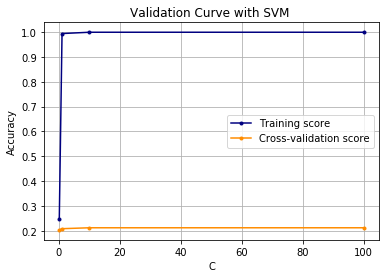

In [7]:
train_scores, test_scores = validation_curve(clf, X_train_multi, y_train_multi, param_name="C", param_range=Cs,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.title("Validation Curve with SVM ")
plt.xlabel('C')
plt.ylabel("Accuracy")

plt.plot(Cs, train_scores_mean, label="Training score",color="navy",marker='.')
plt.plot(Cs, test_scores_mean, label="Cross-validation score",color="darkorange",marker='.')
plt.grid()
plt.legend(loc="best")
plt.show()

In [8]:
print("Parámetro que maximiza la accuracy:",best_param)

Parámetro que maximiza la accuracy: {'C': 10}


In [9]:
print("Tasa de acierto del modelo base:",modelo_base.score(X_test_multi,y_test_multi))
print("Tasa de acierto con la busqueda de parámetros:",svc_clf.score(X_test_multi,y_test_multi))
print('Mejora  del {:0.2f}%.'.format( 100 * (svc_clf.score(X_test_multi,y_test_multi) - modelo_base.score(X_test_multi,y_test_multi)) / modelo_base.score(X_test_multi,y_test_multi)))

Tasa de acierto del modelo base: 0.17277486910994763
Tasa de acierto con la busqueda de parámetros: 0.16230366492146597
Mejora  del -6.06%.


### 1.4 Evaluación del modelo

In [10]:
predict = svc_clf.predict(X_test_multi)

acc_test= svc_clf.score(X_test_multi, y_test_multi).round(4)
acc_train= svc_clf.score(X_train_multi, y_train_multi).round(4)

print('La exactitud para el modelo de SVM en el conjunto de TEST es:',acc_test,'\n')
print('La exactitud para el modelo de SVM en el conjunto de TRAIN es:',acc_train,'\n')

print("=============== Classification Report ================")
print(classification_report(y_test_multi, predict))

La exactitud para el modelo de SVM en el conjunto de TEST es: 0.1623 

La exactitud para el modelo de SVM en el conjunto de TRAIN es: 0.9988 

=============== Classification Report ================
              precision    recall  f1-score   support

         0.0       0.06      0.03      0.04        33
         1.0       0.00      0.00      0.00        43
         2.0       0.20      0.03      0.05        39
         3.0       0.00      0.00      0.00        43
         5.0       0.18      0.88      0.29        33

    accuracy                           0.16       191
   macro avg       0.09      0.19      0.08       191
weighted avg       0.08      0.16      0.07       191



In [11]:
matriz_confusion=pd.crosstab(y_test_multi,predict, rownames=['Clase predicha'], colnames=['Resultado del clasificador'])
matriz_confusion

Resultado del clasificador,0.0,1.0,2.0,3.0,5.0
Clase predicha,,,,,
0.0,1,1,0,0,31
1.0,3,0,3,0,37
2.0,4,2,1,1,31
3.0,5,1,1,0,36
5.0,3,0,0,1,29


### 1.5 Visualización de resultados

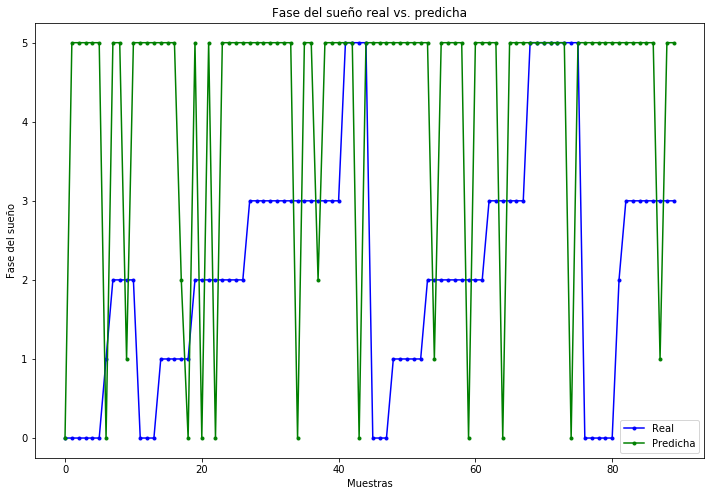

In [12]:
plt.figure(figsize=(12,8))
plt.plot(y_test_multi[0:90],color='blue', marker='.',label='Real')
plt.plot(predict[0:90],color='green', marker='.',label='Predicha')

plt.title('Fase del sueño real vs. predicha')
plt.xlabel('Muestras')
plt.ylabel('Fase del sueño')
plt.legend()

**Residuos**

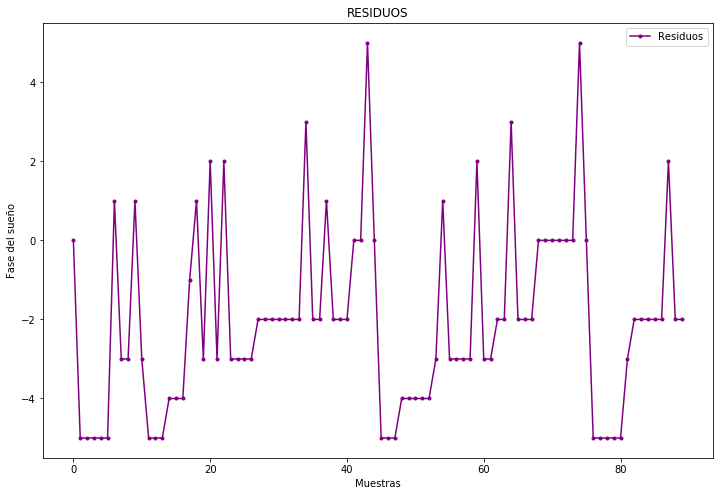

In [13]:
residuos= y_test_multi - predict
plt.figure(figsize=(12,8))
plt.plot(residuos[0:90],color='purple', marker='.',label='Residuos')

plt.title('RESIDUOS')
plt.xlabel('Muestras')
plt.ylabel('Fase del sueño')
plt.legend()